# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA, но уже 64x64

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [ ]:
ON_COLAB = False

if ON_COLAB:
    ! git clone https://github.com/SpirinEgor/HSE.gans.git
    %cd HSE.gans

In [1]:
import fileinput
from math import log
from os.path import exists

import numpy as np
import requests
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils

from homework_3.glow import Glow
from homework_3.train_utils import train_loop
from homework_3.vae import Vae64x64

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%capture

! pip install --upgrade --no-cache-dir gdown

In [2]:
url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/utils/datasets/celeba.py"
if not exists("celeba.py"):
    with open("celeba.py", "wb") as f:
        f.write(requests.get(url).content)

for line in fileinput.input("celeba.py", inplace=True):
    if fileinput.filelineno() not in [45, 46]:
        print(line[:-1])
        continue
    if fileinput.filelineno() == 45:
        corrected_line = "                download_url = 'https://drive.google.com/file/d/17NNnHn1RyPPmb4iQqIGJ2XFulfwyW1Sh/view?usp=sharing'"
    else:
        corrected_line = "                gdown.download(download_url, download_path, quiet=False, fuzzy=True)"
    print(corrected_line)

url = "https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt"
if not exists("list_attr_celeba.txt"):
    with open("list_attr_celeba.txt", "wb") as f:
        f.write(requests.get(url).content)

from celeba import CelebADataset

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

In [3]:
class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image


transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

dataset = CelebaCustomDataset(transform=transform, attr_file_path="list_attr_celeba.txt", crop=True)

### Визуализация датасета

In [4]:
def plot_img(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")

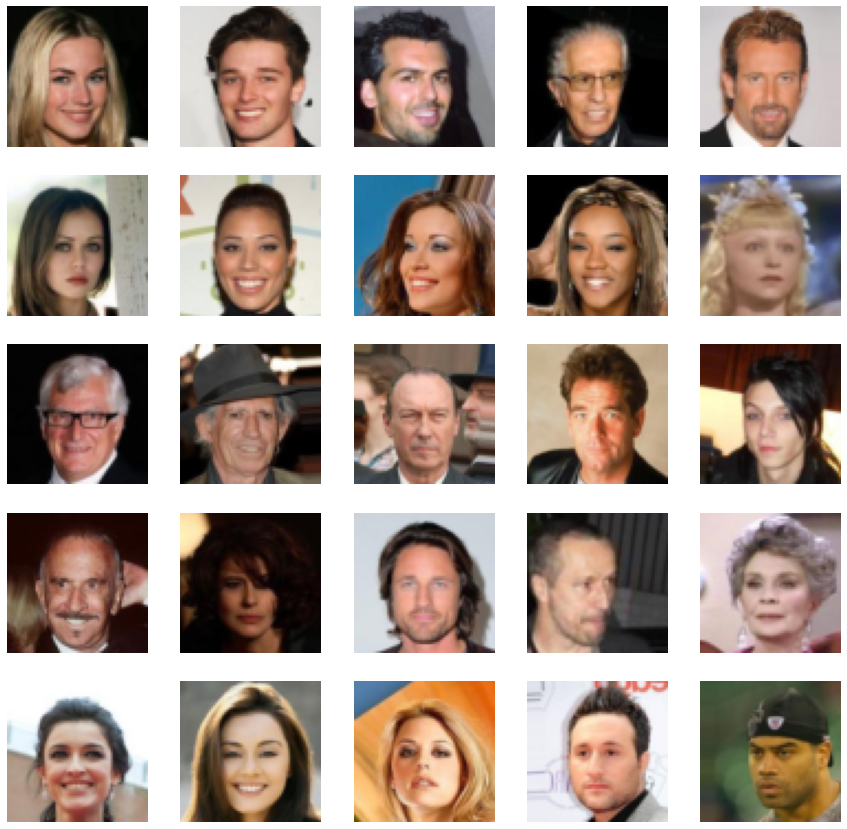

In [5]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img)

plt.show()

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [7]:
def calc_size(net):
    param_size = 0
    for param in net.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in net.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    gen_size = (param_size + buffer_size) / 1024**2
    return gen_size

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA 64x64

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но он довольно плохой и неэффективный) Лучше написать свой

In [8]:
N_BITS = 5
N_BINS = 2**N_BITS
SAMPLE_TEMP = 0.7


def glow_loss(log_p, log_det, image_size):
    n_pixel = image_size * image_size * 3

    loss = -log(N_BINS) * n_pixel
    loss += log_det + log_p

    return (-loss / (log(2) * n_pixel)).mean()


def quantize_preprocess(images):
    images = images * 255  # undo ToTensor scaling to [0,1]
    if N_BITS < 8:
        images = torch.floor(images / 2 ** (8 - N_BITS))
    images = images / N_BINS - 0.5
    return images


def quantize_postprocess(images):
    images = torch.clamp(images, -0.5, 0.5) + 0.5
    images = images * N_BINS
    return torch.clamp(images, 0, 255).byte()


def glow_train_step(glow_model, images):
    images = quantize_preprocess(images)
    noise = torch.zeros_like(images).uniform_(0, 1.0 / N_BINS)
    log_p, log_det, _ = glow_model(images + noise)
    log_det = log_det.mean()
    loss = glow_loss(log_p, log_det, images.shape[-1])
    return loss

In [35]:
glow_celeba = Glow(k_flow=32, l_block=3, n_filters=512).to(device)
print(f"model size: {calc_size(glow_celeba):.3f} MB")

model size: 168.586 MB


In [36]:
glow_celeba_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

z_shapes = glow_celeba.get_sample_noise_shapes(dataset[0].shape[-1])
z_noise = [torch.randn(25, *z, device=device) * SAMPLE_TEMP for z in z_shapes]

glow_losses = train_loop(
    glow_celeba, glow_celeba_dataloader, z_noise, glow_train_step, device, n_epochs=1, lr=0.0001, decay_gamma=0.95
)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/31 [00:00<?, ?it/s]

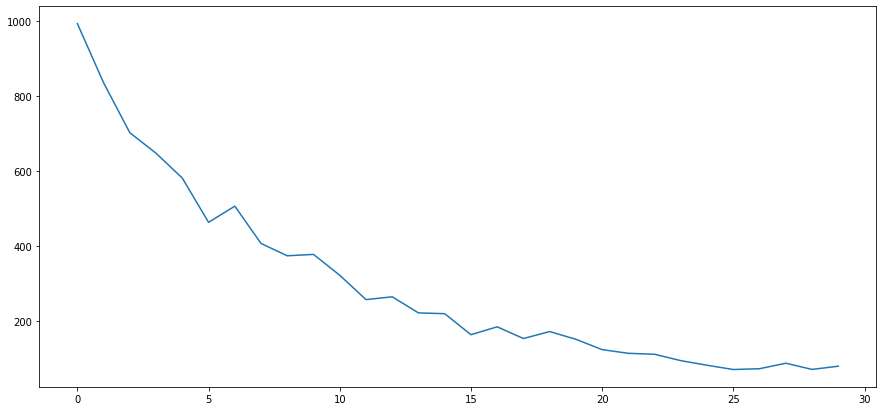

In [39]:
plt.figure(figsize=(15, 7))
plt.plot(glow_losses[1:])
plt.show()

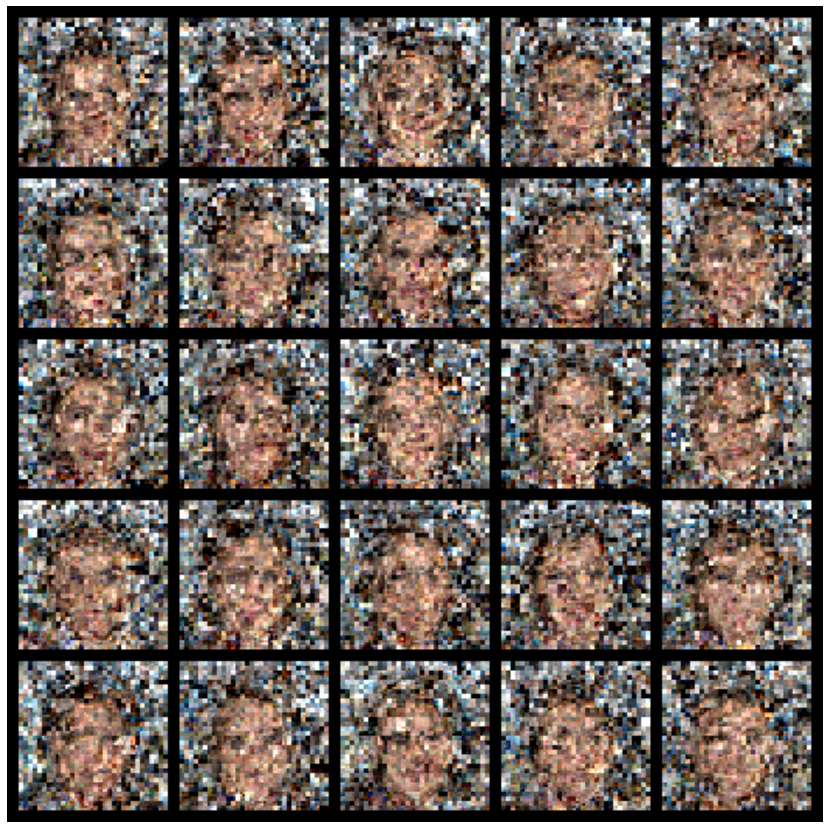

In [38]:
glow_celeba.eval()
img = glow_celeba.sample(z_noise).detach().cpu()

plt.figure(figsize=(15, 15))
grid = utils.make_grid(img, nrow=5, padding=5)
plot_img(grid)

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA 64x64

Здесь нужно обучить VAE до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [13]:
KLD_LAMBDA = 0.1


def vae_loss(x, reconstruct, mu, log_sigma):
    element_wise = F.mse_loss(x, reconstruct, reduction="none")
    reconstruction_loss = element_wise.reshape(x.shape[0], -1).sum(dim=1).mean()

    kld_loss = (0.5 * (torch.exp(2 * log_sigma) + mu**2 - 2 * log_sigma - 1)).sum(dim=1).mean()

    loss = reconstruction_loss + KLD_LAMBDA * kld_loss
    return loss


def vae_train_step(vae_model, images):
    images = 2 * images - 1
    reconstruct, z, mu, log_sigma = vae_model(images)
    loss = vae_loss(images, reconstruct, mu, log_sigma)
    return loss

In [14]:
vae_celeba = Vae64x64(latent_dim=128).to(device)
print(f"model size: {calc_size(vae_celeba):.3f} MB")

model size: 15.032 MB


In [15]:
vae_celeba_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
z_noise = torch.randn(25, vae_celeba.latent_dim, device=device)
vae_losses = train_loop(
    vae_celeba, vae_celeba_dataloader, z_noise, vae_train_step, device, n_epochs=20, lr=0.005, decay_gamma=0.95
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/8 [00:00<?, ?it/s]

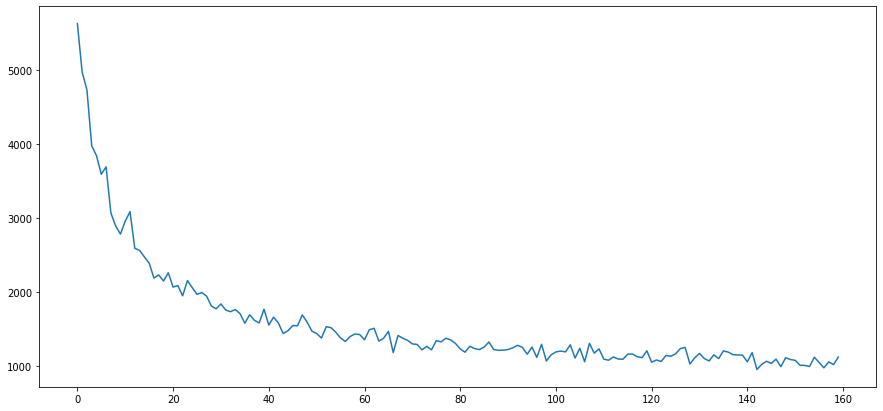

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(vae_losses)
plt.show()

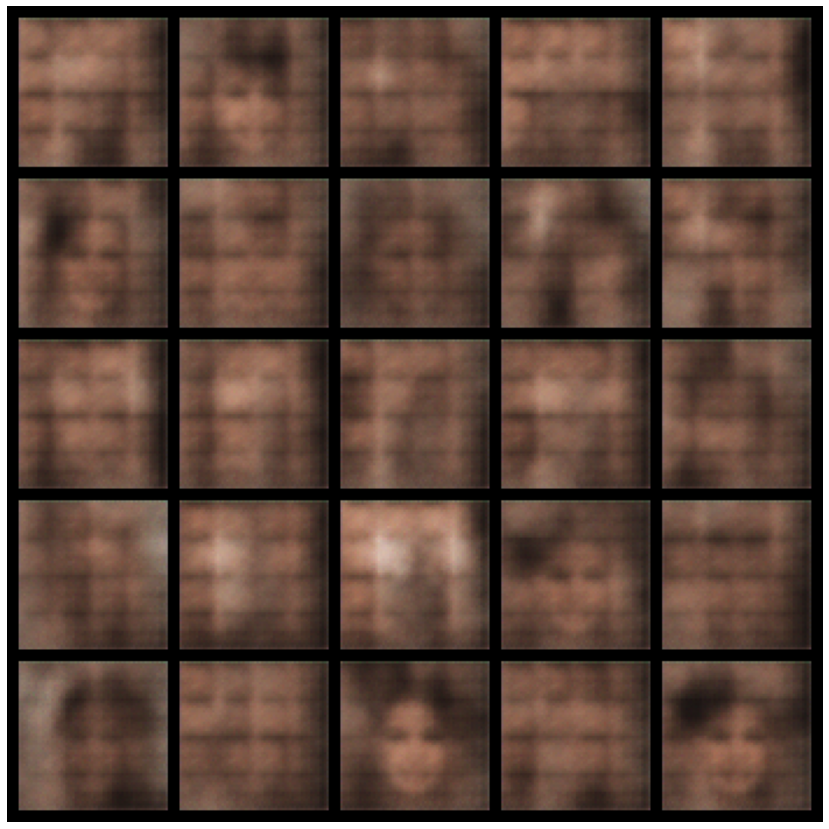

In [17]:
vae_celeba.eval()
img = vae_celeba.sample(z_noise).detach().cpu()

plt.figure(figsize=(15, 15))
grid = utils.make_grid(img, nrow=5, padding=5)
plot_img(grid)

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA 64x64

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA 64x64

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [ ]:
# YOUR CODE HERE

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.